In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit, ShuffleSplit
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


In [70]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2022-04-01 00:00", end_index="2023-03-31 23:59")

contamination = 0.05
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

In [71]:
def compute_lag_df(y, min_lag, max_lag):
    lag_values = list(range(min_lag, max_lag+1))

    name = y.columns[0]
    for lag in lag_values:
        kwargs = {name+"_shift"+str(lag): y[name].shift(lag)}
        y = y.assign(**kwargs)
        # y = pd.concat([y, y[name].shift(lag)], axis=1)

    y = y.drop(name, axis=1)
    return y

In [72]:
def compute_lag_fh_df(y, min_lag, max_lag, fh):
    return pd.concat([y.shift(-fh+1), compute_lag_df(y, min_lag, max_lag)], axis=1)

In [73]:
def compute_ml_ts_data(y, X, min_lag, max_lag, fh, add_year = True, add_month=True, add_day=True, add_hour=True):
    y = pd.DataFrame(y)

    if add_year:
        X['year'] = y.index.year
    if add_month:
        X['month'] = y.index.month
    if add_day:
        X['day'] = y.index.day

    if add_hour:
        X['hour'] = y.index.hour
        df = pd.concat([compute_lag_fh_df(y, min_lag, max_lag, fh), X], axis=1)
        df = df.copy()
        return df.dropna()

In [74]:
def cv_predictor_importance(y, X, min_lag, max_lags, fh, n_splits, test_size, add_year=True, add_month=True, add_day=True, add_hour=True):
    # param_knn = {"n_neighbors": [3, 5, 7, 12, 15],
    #              "p": [1, 2, 3]}
    # param_rf = {"max_depth": [6, 9, 12, 15, 20, None],
    #             "min_samples_split": [7, 11, 13, 15, 21]}
    # param_gb = {"n_estimators": [50, 70, 100, 130, 170, 200],
    #             "min_samples_leaf": [1, 3, 5, 10]}
    # param_svm = {'C': [0.1, 0.5, 1, 5, 10, 30, 50],
    #              'kernel': ['rbf', 'poly', 'sigmoid']}
    param_knn = {"n_neighbors": [5],
                 "p": [2]}
    param_rf = {"max_depth": [None],
                "min_samples_split": [2]}
    param_gb = {"n_estimators": [100],
                "min_samples_split": [2]}
    param_svm = {'C': [1.0],
                 'kernel': ['rbf']}
    param_list = [param_knn, param_rf, param_gb, param_svm]


    regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
    regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

    models_shap_cv = pd.DataFrame(columns=['max_lag', 'model', 'parameters', 'mae'])
    for max_lag in max_lags:
        ml_data = compute_ml_ts_data(y, X, min_lag, max_lag, fh, add_year, add_month, add_day, add_hour)
        for regressor, regressor_str, param in zip(regressor_list, regressor_str_list, param_list):
            print(f"Training setup: min lag {min_lag}, max_lag {max_lag} and regressor {regressor_str}. ", sep="", end="")
            X_ml = ml_data.iloc[:, 1:]
            y_ml = ml_data.iloc[:, 0]

            #cv = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2)
            cv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
            gs = GridSearchCV(regressor, param,
                              scoring="neg_mean_absolute_error",
                              cv=cv,
                              verbose=1,
                              n_jobs=7
                              )

            gs.fit(X_ml, y_ml)
            row = [max_lag, regressor_str, gs.best_params_, -gs.best_score_]
            models_shap_cv = models_shap_cv.append(pd.Series(row, index=models_shap_cv.columns), ignore_index=True)

    return models_shap_cv

In [ ]:
def cv_predictor_importance(y, X, min_lag, max_lags, fh, n_splits, test_size, add_year=True, add_month=True, add_day=True, add_hour=True):
    # param_knn = {"n_neighbors": [3, 5, 7, 12, 15],
    #              "p": [1, 2, 3]}
    # param_rf = {"max_depth": [6, 9, 12, 15, 20, None],
    #             "min_samples_split": [7, 11, 13, 15, 21]}
    # param_gb = {"n_estimators": [50, 70, 100, 130, 170, 200],
    #             "min_samples_leaf": [1, 3, 5, 10]}
    # param_svm = {'C': [0.1, 0.5, 1, 5, 10, 30, 50],
    #              'kernel': ['rbf', 'poly', 'sigmoid']}
    param_knn = {"n_neighbors": [5],
                 "p": [2]}
    param_rf = {"max_depth": [None],
                "min_samples_split": [2]}
    param_gb = {"n_estimators": [100],
                "min_samples_split": [2]}
    param_svm = {'C': [1.0],
                 'kernel': ['rbf']}
    param_list = [param_knn, param_rf, param_gb, param_svm]


    regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
    regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

    models_shap_cv = pd.DataFrame(columns=['max_lag', 'model', 'parameters', 'mae'])
    for max_lag in max_lags:
        ml_data = compute_ml_ts_data(y, X, min_lag, max_lag, fh, add_year, add_month, add_day, add_hour)
        for regressor, regressor_str, param in zip(regressor_list, regressor_str_list, param_list):
            print(f"Training setup: min lag {min_lag}, max_lag {max_lag} and regressor {regressor_str}. ", sep="", end="")
            X_ml = ml_data.iloc[:, 1:]
            y_ml = ml_data.iloc[:, 0]

            #cv = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2)
            cv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
            gs = GridSearchCV(regressor, param,
                              scoring="neg_mean_absolute_error",
                              cv=cv,
                              verbose=1,
                              n_jobs=7
                              )

            gs.fit(X_ml, y_ml)
            row = [max_lag, regressor_str, gs.best_params_, -gs.best_score_]
            models_shap_cv = models_shap_cv.append(pd.Series(row, index=models_shap_cv.columns), ignore_index=True)

    return models_shap_cv

In [75]:
regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

In [77]:
min_lag = 1
max_lags = [24*i for i in [1, 2, 5, 7, 14]]
max_lags = [24*i for i in [7]]

test_proportion = 0.2
cv_partitions = 5
test_partition_size = math.floor(len(esios_spot)/cv_partitions * test_proportion)
test_partition_size= 168

## 1 hour forecast horizon

In [78]:
fh = 1
models_shap_cv_1fh = cv_predictor_importance(esios_spot, X, min_lag, max_lags, fh, cv_partitions, test_partition_size, add_year=False)

Training setup: min lag 1, max_lag 168 and regressor KNeighborsRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor RandomForestRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor GradientBoostingRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor SVR. Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [79]:
models_shap_cv_1fh = models_shap_cv_1fh.sort_values(by="mae")
models_shap_cv_1fh

,max_lag,model,parameters,mae
2,168,GradientBoostingRegressor,"{'min_samples_split': 2, 'n_estimators': 100}",6.92891
1,168,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2}",7.125676
0,168,KNeighborsRegressor,"{'n_neighbors': 5, 'p': 2}",25.721154
3,168,SVR,"{'C': 1.0, 'kernel': 'rbf'}",29.152596


In [80]:
best_max_lag = models_shap_cv_1fh.iloc[0,0]
ml_data = compute_ml_ts_data(esios_spot, X, min_lag, best_max_lag, fh=1, add_year=False)

X_train, X_test, y_train, y_test = train_test_split(ml_data.iloc[:, 1:], ml_data.iloc[:,0], test_size=test_proportion, shuffle=False)

best_model_string = models_shap_cv_1fh.iloc[0,1]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
best_model_params = models_shap_cv_1fh.iloc[0,2]
best_model_params["random_state"] = 0
shap_model = best_model.set_params(**best_model_params)

print(f"Using model {best_model_string} with configuration {best_model_params} and {best_max_lag} lags")
shap_model.fit(X_train, y_train)

y_pred = shap_model.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index).set_axis(['prediction'], axis='columns')

print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R squared:", r2_score(y_test, y_pred))

Using model GradientBoostingRegressor with configuration {'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0} and 168 lags
Mean absolute error: 6.984743241595463
R squared: 0.9548644333993245


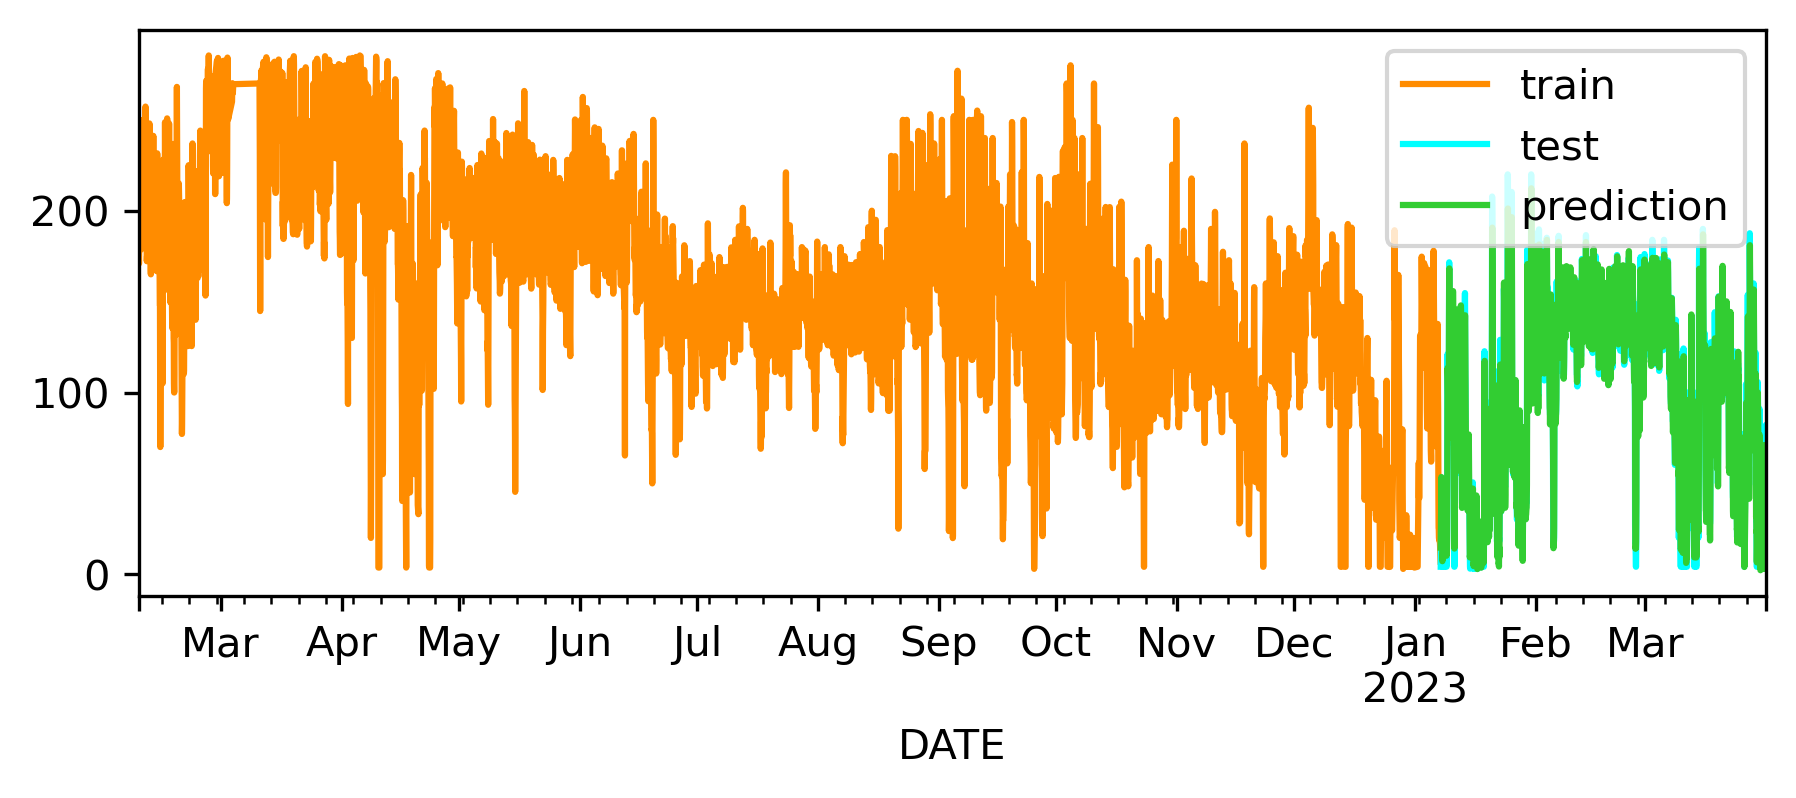

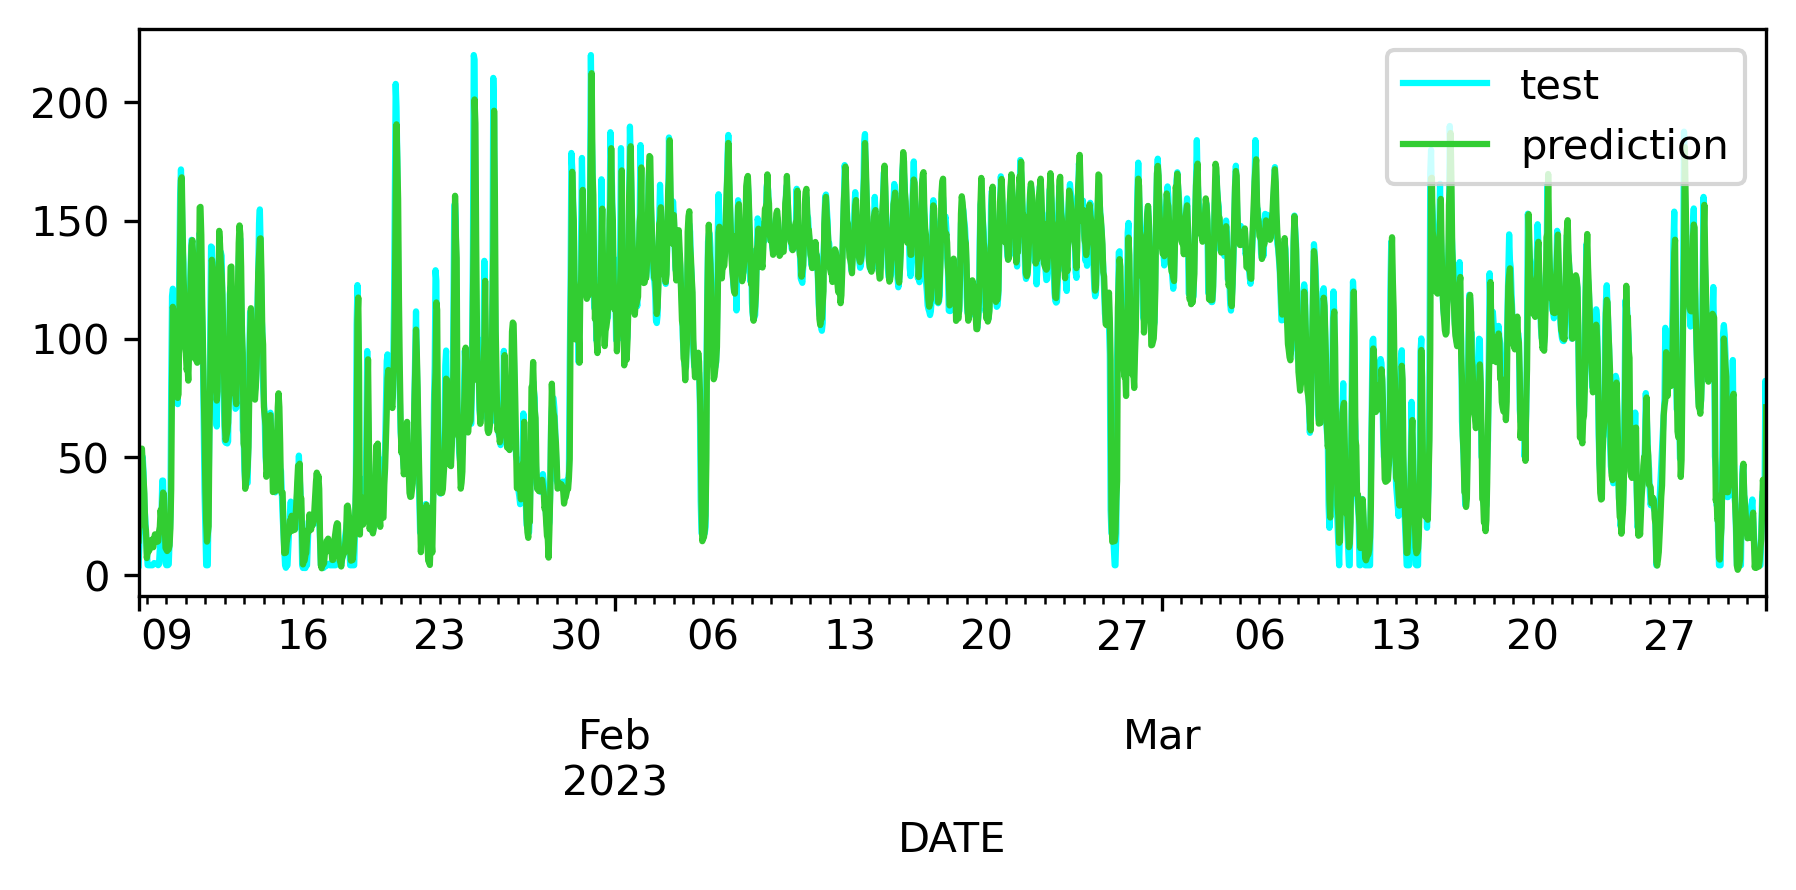

In [81]:
fig, ax = plt.subplots(figsize=(7, 2.5))
y_train.plot(ax=ax, label="train", color="darkorange")
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

fig, ax = plt.subplots(figsize=(7, 2.5))
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

Permutation explainer: 2003it [07:30,  4.31it/s]                          


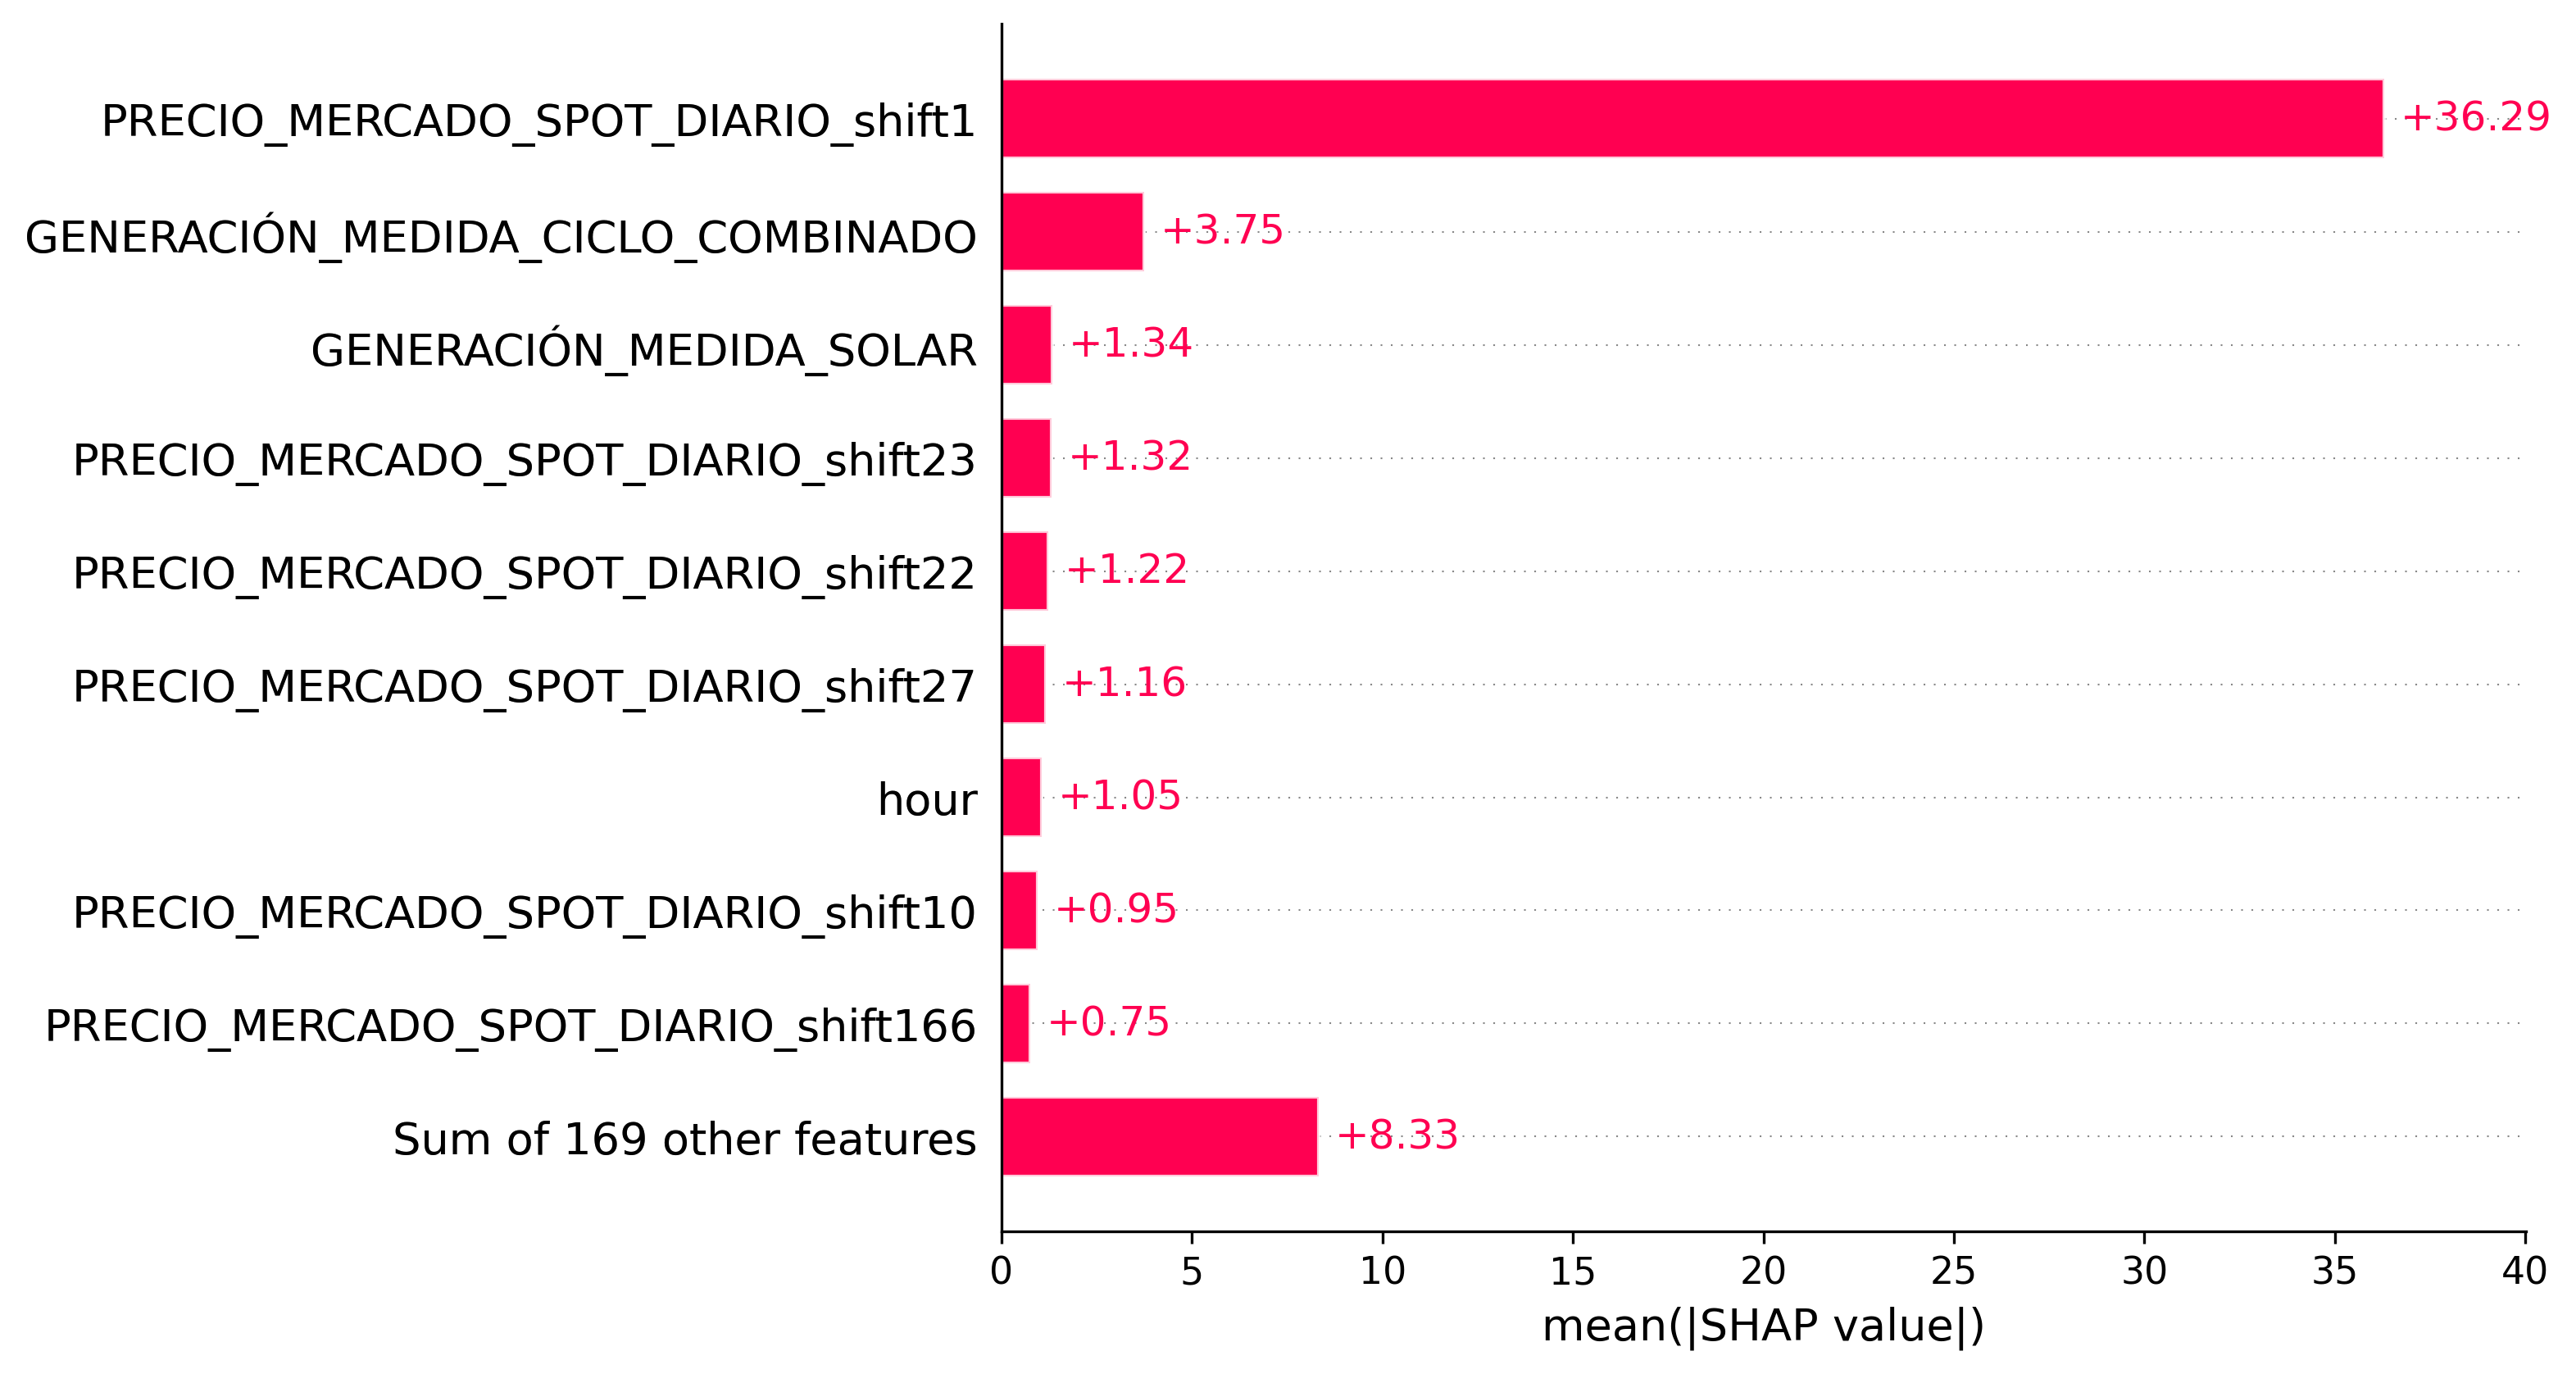

In [82]:
explainer = shap.Explainer(shap_model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

## 24 hours forecast horizon

In [57]:
lag_sizes = [24*i for i in [7]]

In [58]:
fh = 24
models_shap_cv_24fh = cv_predictor_importance(esios_spot, X, min_lag, max_lags, fh, cv_partitions, test_partition_size, add_year=False)

Training setup: min lag 1, max_lag 168 and regressor KNeighborsRegressor. Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training setup: min lag 1, max_lag 168 and regressor RandomForestRegressor. Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training setup: min lag 1, max_lag 168 and regressor GradientBoostingRegressor. Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training setup: min lag 1, max_lag 168 and regressor SVR. Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [59]:
models_shap_cv_24fh = models_shap_cv_24fh.sort_values(by="mae")
models_shap_cv_24fh

,max_lag,model,parameters,mae
1,168,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2}",26.885893
2,168,GradientBoostingRegressor,"{'min_samples_split': 2, 'n_estimators': 100}",28.37112
3,168,SVR,"{'C': 1.0, 'kernel': 'rbf'}",32.21124
0,168,KNeighborsRegressor,"{'n_neighbors': 5, 'p': 2}",33.449371


In [60]:
best_max_lag = models_shap_cv_24fh.iloc[0, 0]
ml_data = compute_ml_ts_data(esios_spot, X, min_lag, best_max_lag, fh=24, add_year=False)

X_train, X_test, y_train, y_test = train_test_split(ml_data.iloc[:, 1:], ml_data.iloc[:, 0],
                                                    test_size=int(len(ml_data) * test_proportion), shuffle=False)

best_model_string = models_shap_cv_24fh.iloc[0, 1]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
best_model_params = models_shap_cv_24fh.iloc[0, 2]
if best_model_string in ["RandomForestRegressor", "GradientBoostingRegressor"]:
    best_model_params["random_state"] = 0
shap_model = best_model.set_params(**best_model_params)

print(f"Using model {best_model_string} with configuration {best_model_params} and {best_max_lag} lags")
shap_model.fit(X_train, y_train)

y_pred = shap_model.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index).set_axis(['prediction'], axis='columns')

print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R squared:", r2_score(y_test, y_pred))

Using model RandomForestRegressor with configuration {'max_depth': None, 'min_samples_split': 2, 'random_state': 0} and 168 lags
Mean absolute error: 26.94620099244648
R squared: 0.4477869154547306


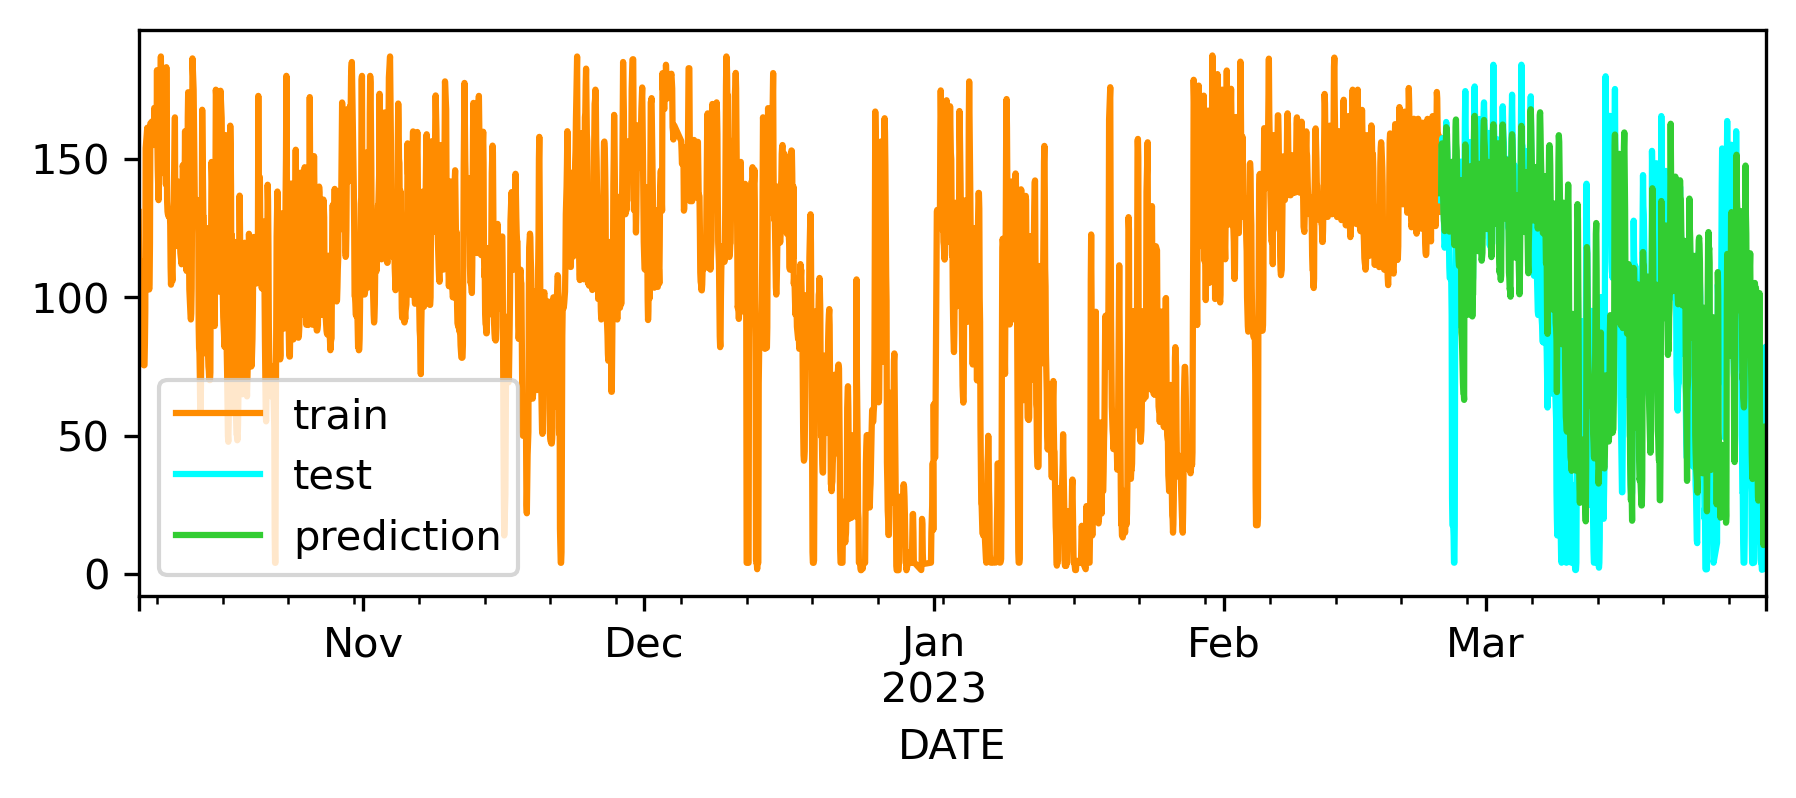

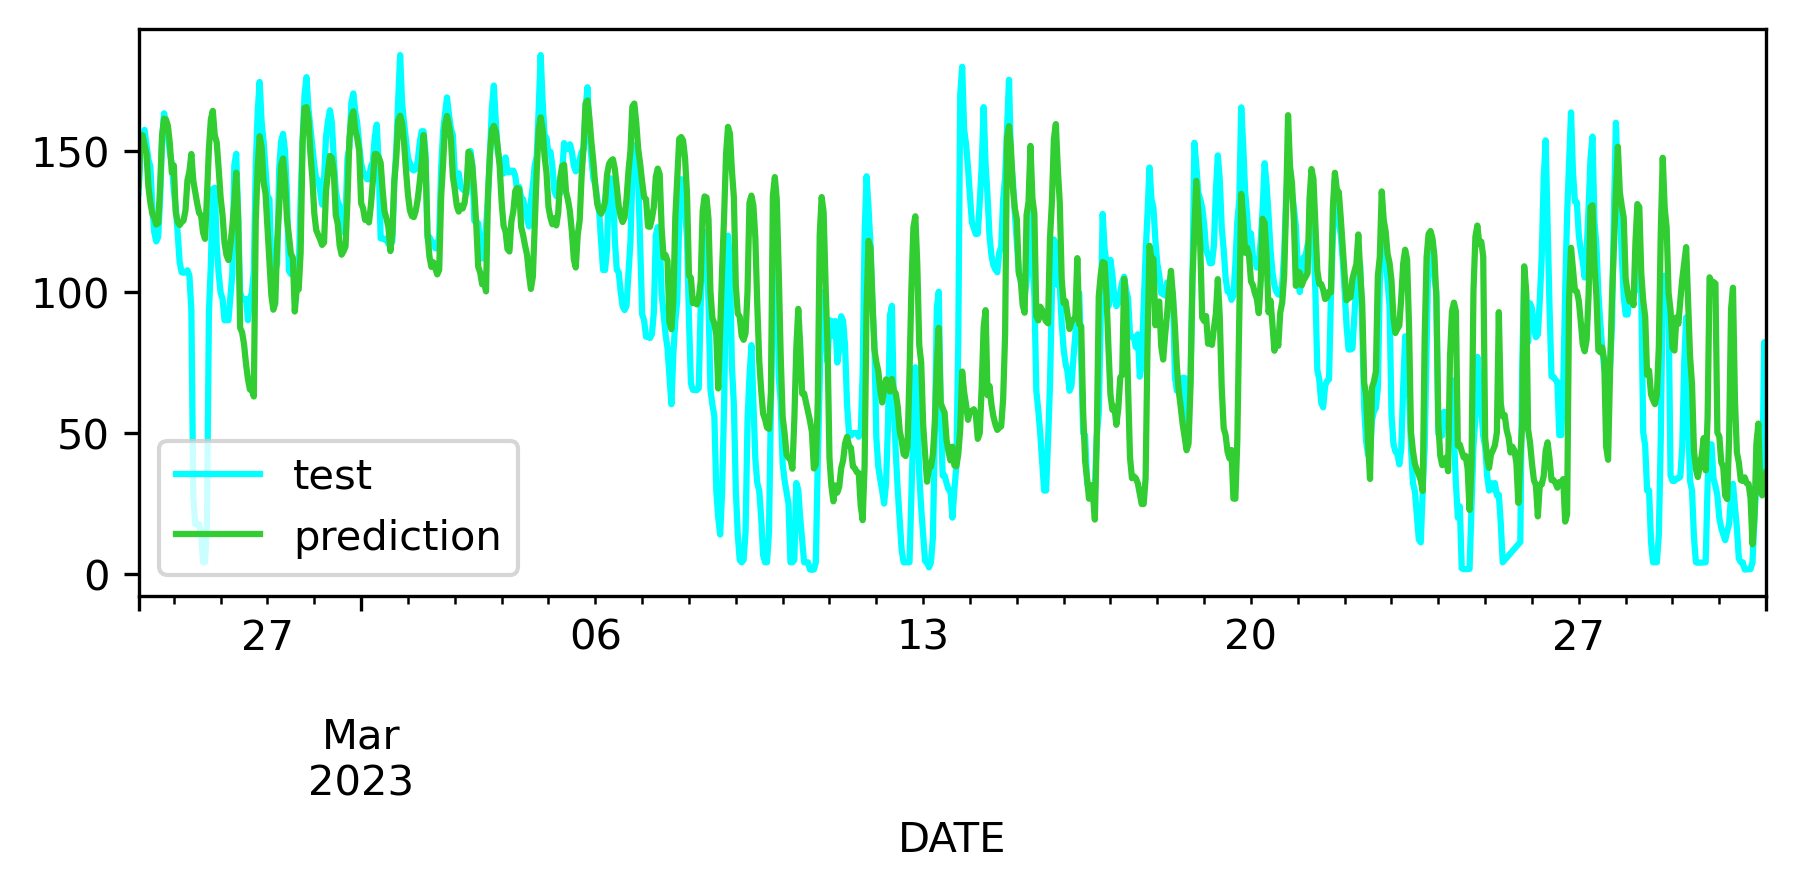

In [61]:
fig, ax = plt.subplots(figsize=(7, 2.5))
y_train.plot(ax=ax, label="train", color="darkorange")
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

fig, ax = plt.subplots(figsize=(7, 2.5))
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

Permutation explainer: 831it [02:33,  5.15it/s]                         


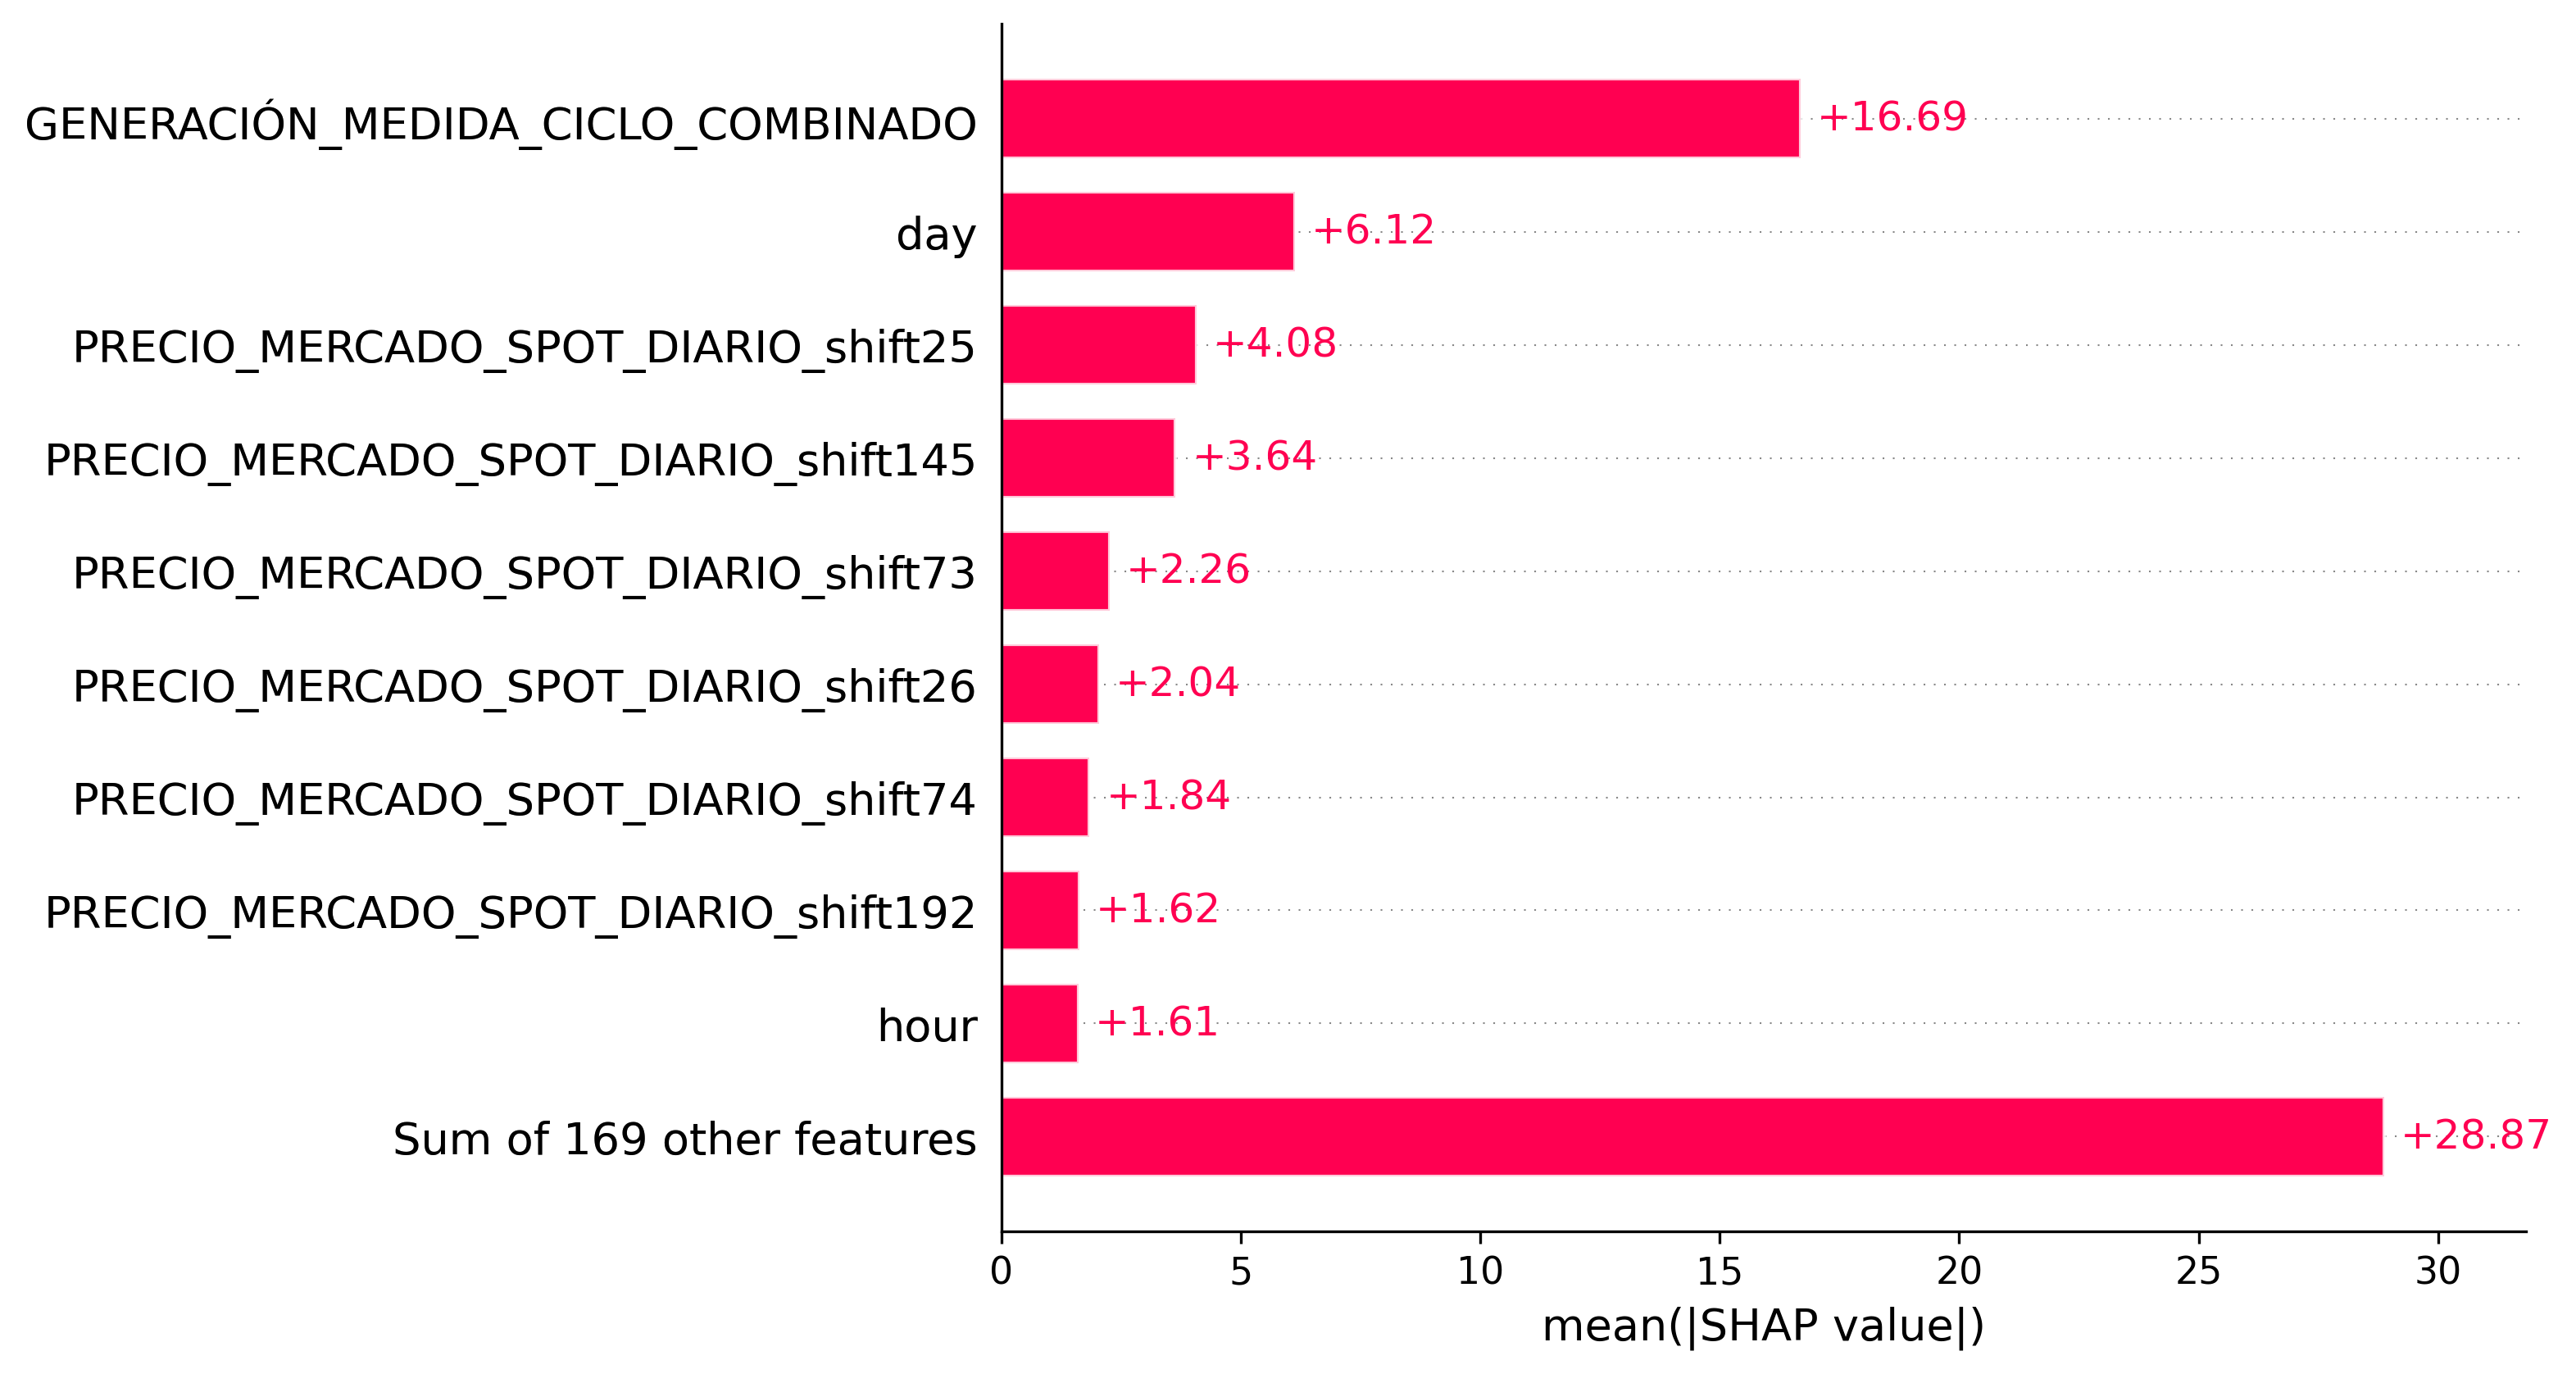

In [38]:
ax.legend()
explainer = shap.Explainer(shap_model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [83]:
lag_sizes = [24*i for i in [14]]

In [84]:
fh = 168
models_shap_cv_168fh = cv_predictor_importance(esios_spot, X, min_lag, max_lags, fh, cv_partitions, test_partition_size, add_year=False)

Training setup: min lag 1, max_lag 168 and regressor KNeighborsRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor RandomForestRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor GradientBoostingRegressor. Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training setup: min lag 1, max_lag 168 and regressor SVR. Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [85]:
models_shap_cv_168fh = models_shap_cv_168fh.sort_values(by="mae")
models_shap_cv_168fh

,max_lag,model,parameters,mae
1,168,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2}",46.638458
2,168,GradientBoostingRegressor,"{'min_samples_split': 2, 'n_estimators': 100}",47.653362
3,168,SVR,"{'C': 1.0, 'kernel': 'rbf'}",50.995763
0,168,KNeighborsRegressor,"{'n_neighbors': 5, 'p': 2}",52.860157


In [86]:
best_max_lag = models_shap_cv_168fh.iloc[0, 0]
ml_data = compute_ml_ts_data(esios_spot, X, min_lag, best_max_lag, fh=24, add_year=False)

X_train, X_test, y_train, y_test = train_test_split(ml_data.iloc[:, 1:], ml_data.iloc[:, 0],
                                                    test_size=int(len(ml_data) * test_proportion), shuffle=False)

best_model_string = models_shap_cv_168fh.iloc[0, 1]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
best_model_params = models_shap_cv_168fh.iloc[0, 2]
if best_model_string in ["RandomForestRegressor", "GradientBoostingRegressor"]:
    best_model_params["random_state"] = 0
shap_model = best_model.set_params(**best_model_params)

print(f"Using model {best_model_string} with configuration {best_model_params} and {best_max_lag} lags")
shap_model.fit(X_train, y_train)

y_pred = shap_model.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index).set_axis(['prediction'], axis='columns')

print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R squared:", r2_score(y_test, y_pred))

Using model RandomForestRegressor with configuration {'max_depth': None, 'min_samples_split': 2, 'random_state': 0} and 168 lags
Mean absolute error: 31.789466169253885
R squared: 0.26374682558346485


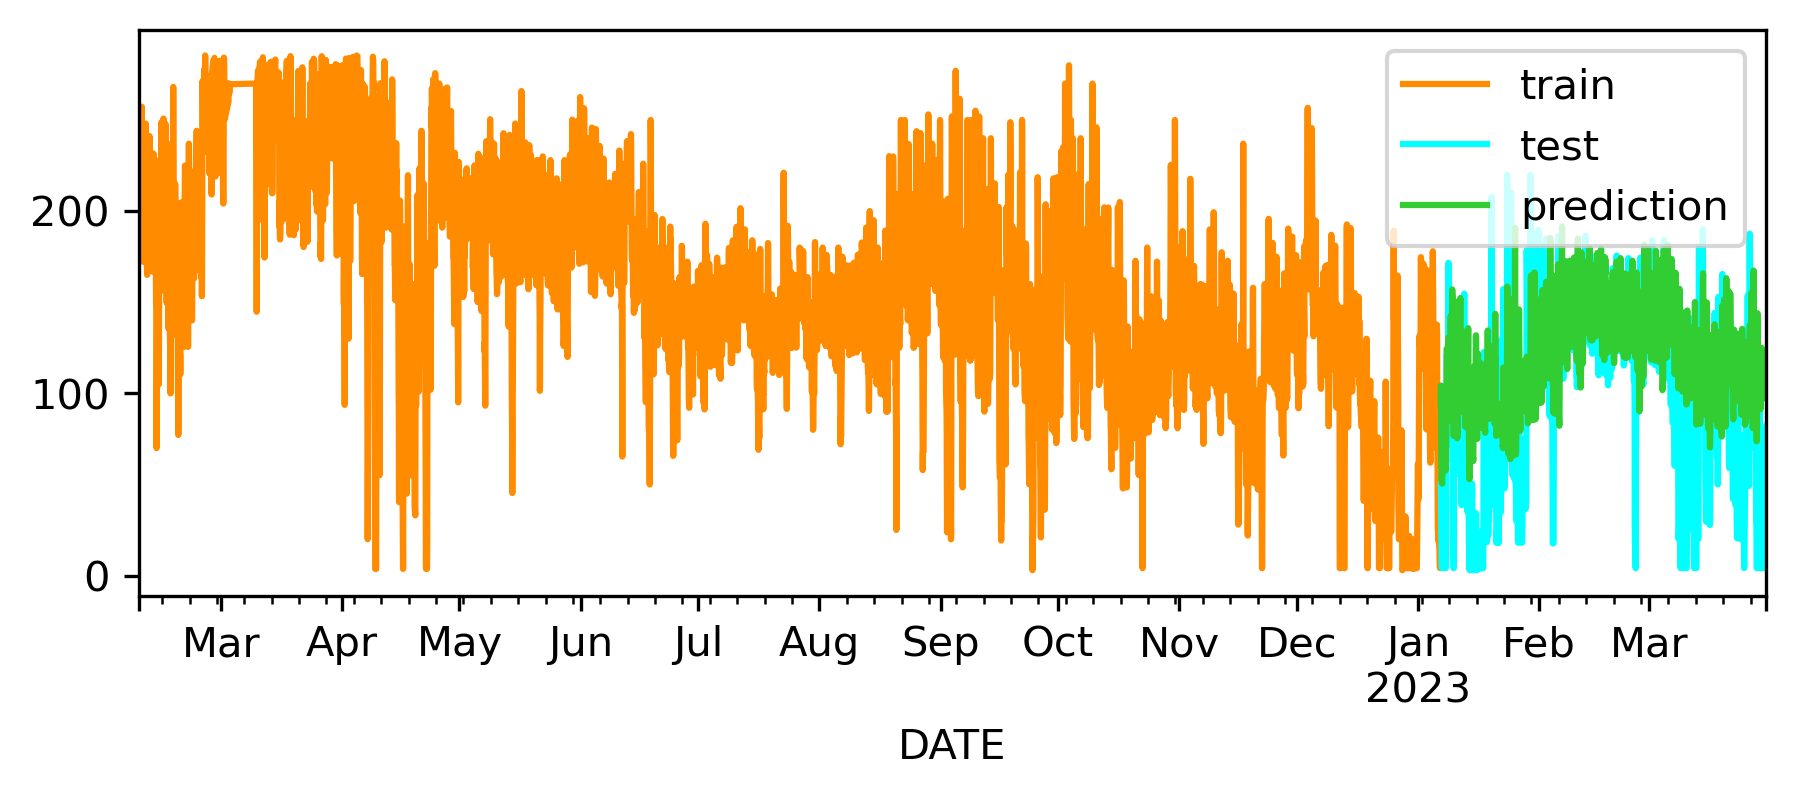

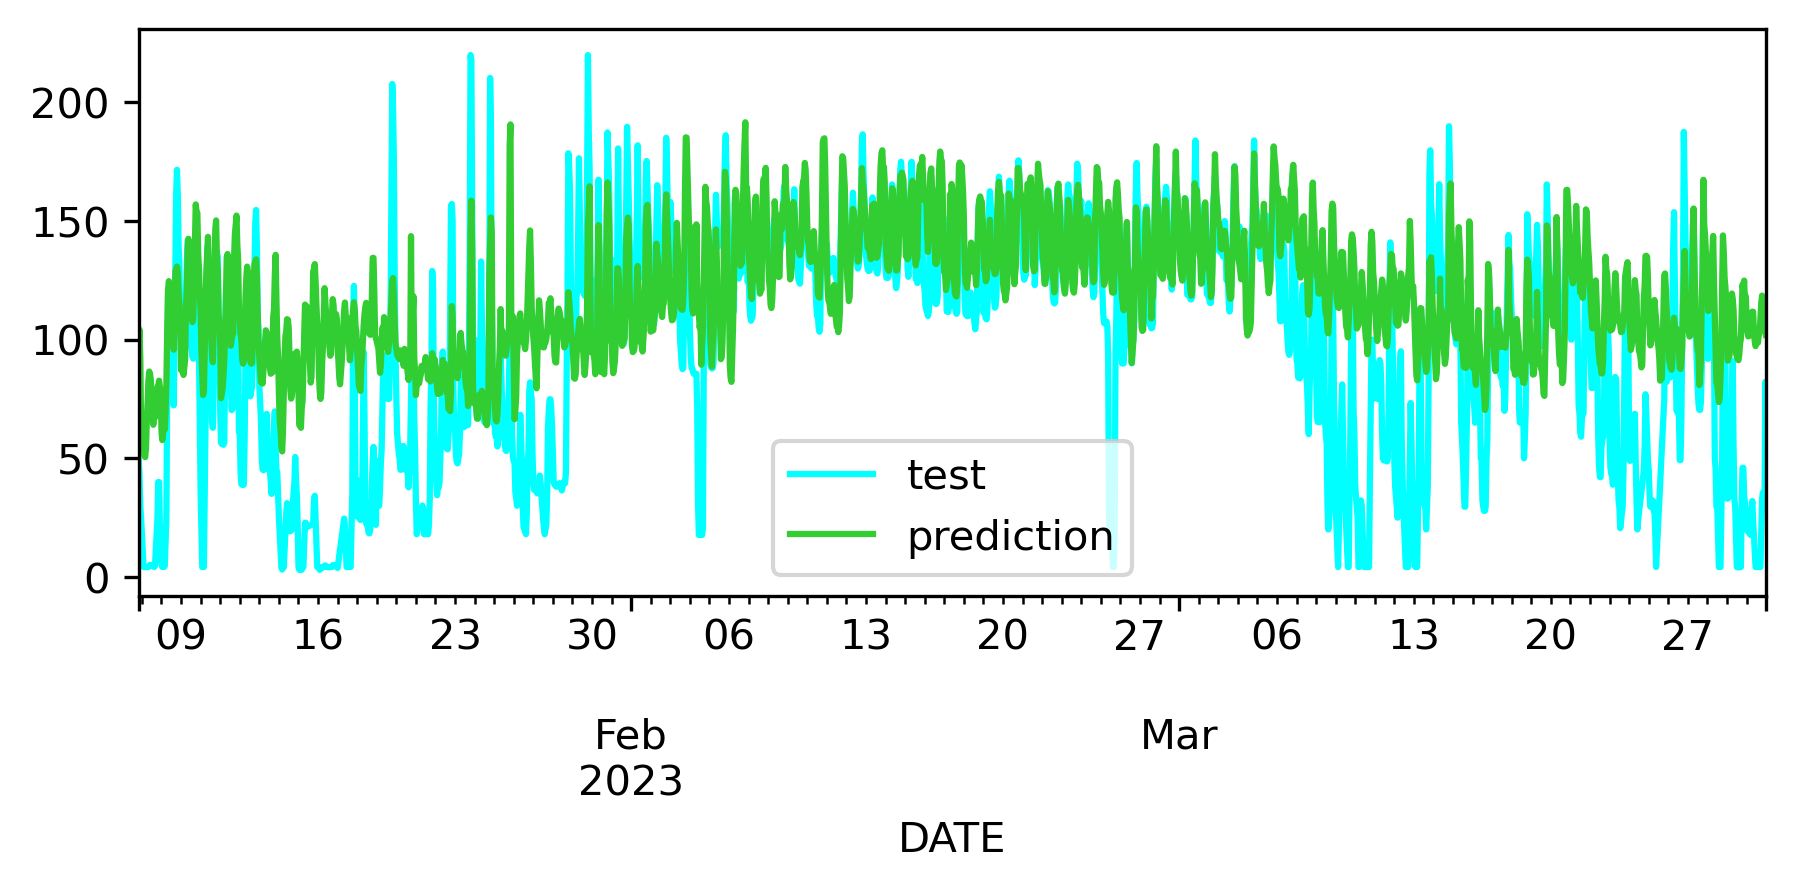

In [87]:
fig, ax = plt.subplots(figsize=(7, 2.5))
y_train.plot(ax=ax, label="train", color="darkorange")
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

fig, ax = plt.subplots(figsize=(7, 2.5))
y_test.plot(ax=ax, label='test', color="cyan")
y_pred.plot(ax=ax, label='predictions', color="limegreen")
ax.legend()

Permutation explainer: 1998it [20:53,  1.58it/s]                          


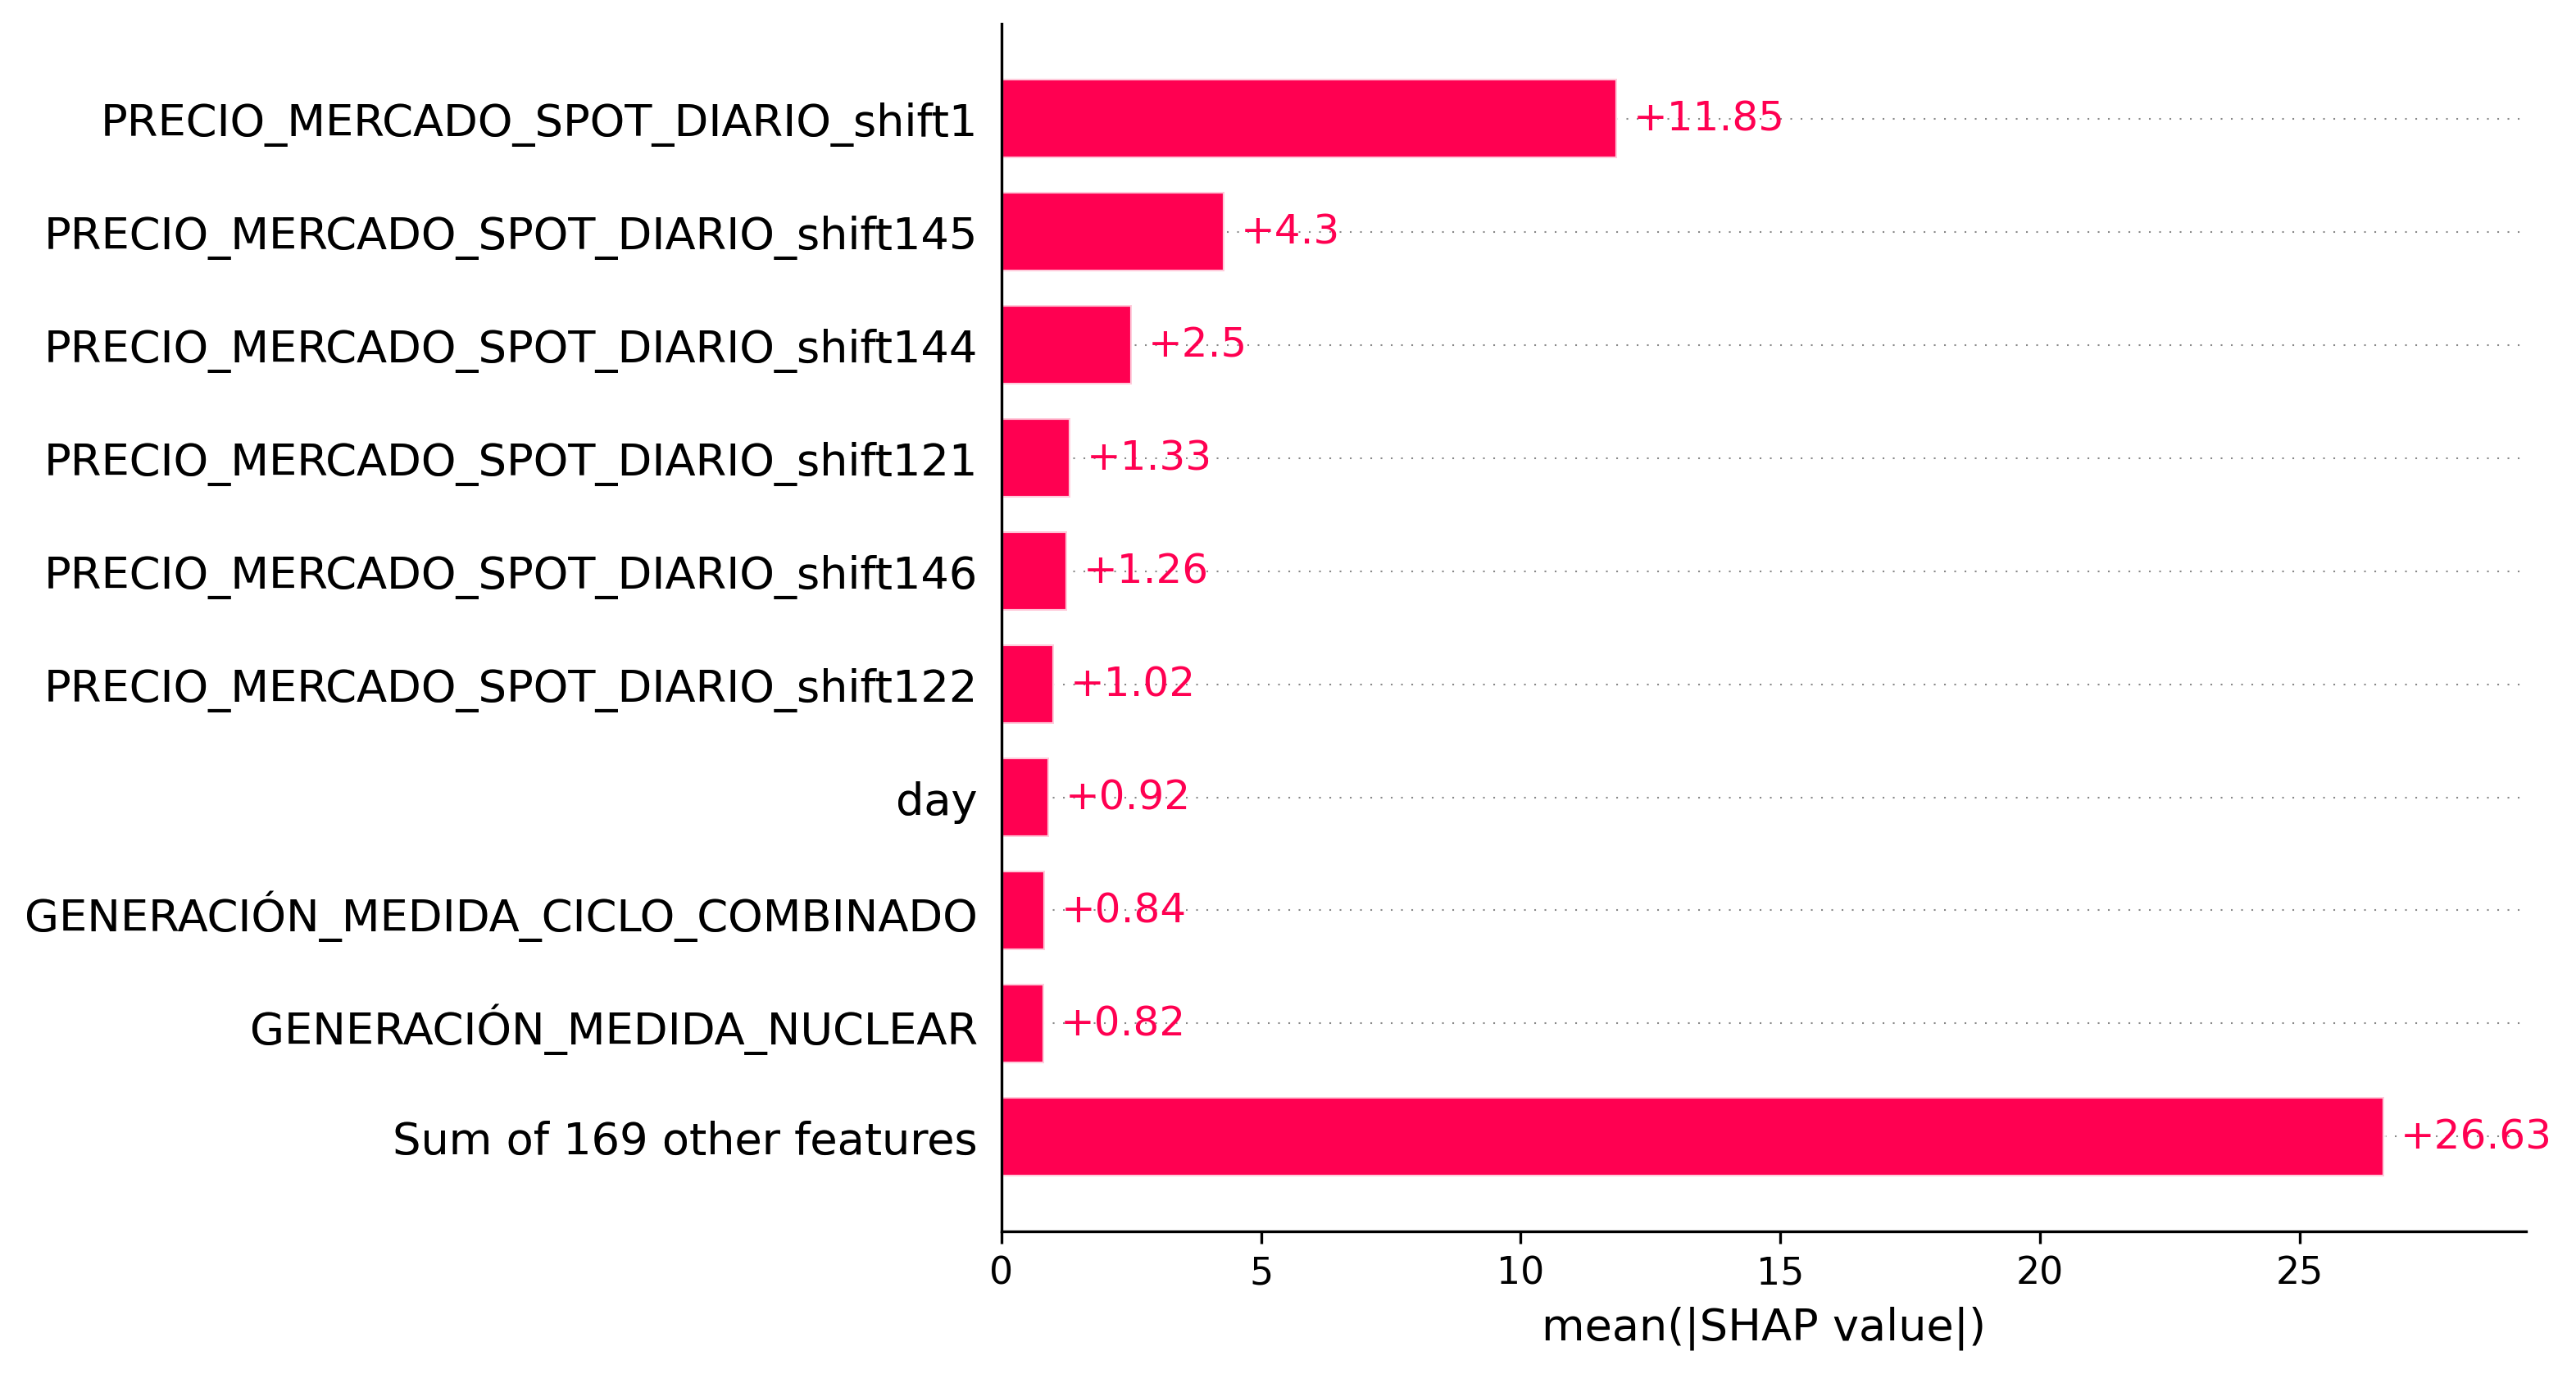

In [88]:
ax.legend()
explainer = shap.Explainer(shap_model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)